In [1]:
# Import
from nilearn import datasets
from nilearn import surface
from nilearn import plotting
from nilearn import image
import numpy as np
import pandas as pd
import glob
import os
from nilearn import signal
from scipy import stats
import nibabel as nib
from os.path import exists
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [31]:
# Load subject fmri data
# This will loop across subjects
projectdir = '/scratch/groups/jyeatman/LMB_BIDS/derivatives/fmriprep/'
inputdir = projectdir
outputdir = '/scratch/groups/jyeatman/LMB_Connectivity/'
#subs = glob.glob(datadir + 'sub-*') # this gets the full path
subs = [os.path.splitext(os.path.basename(x))[0] for x in glob.glob(inputdir + '/sub-*.html')]
print('Found ' + str(len(subs)) + ' subjects in inputdir')
print(subs)

Found 24 subjects in inputdir
['sub-173', 'sub-1452', 'sub-1215', 'sub-108', 'sub-1210', 'sub-1380', 'sub-1362', 'sub-984', 'sub-230', 'sub-641', 'sub-2130', 'sub-1339', 'sub-1234', 'sub-1395', 'sub-1468', 'sub-1335', 'sub-107', 'sub-309', 'sub-2158', 'sub-1211', 'sub-1021', 'sub-1444', 'sub-1453', 'sub-1020']


In [32]:
# Define our data and set paths
#subs = ['107', '108', '173', '230', '309', '984', '1210', '1211', '1215','1234', '1335','1339','1380','1452','1453']
#sessions = ['1','2','3','4']
runs = ['1','2']
overwrite = False
saveFigs = False # Save png files of connectivity maps
saveMaps = False # Save actual connectivity map as a curv file that can 
# be loaded to Freeview
saveGroup = True

datadir = '/scratch/groups/jyeatman/LMB_BIDS/derivatives/fmriprep/'

# Paths to surface ROIs from Emily
roidir =  '/home/groups/jyeatman/ROI_Atlases/visfAtlas/Emily/'
roi_names = ['lh_pOTS_chars.label','lh_mOTS_chars.label','MPM_lh_IOS.label']
# the IOS ROI is a character selective ROI from Rosenke 2021, looks like OWFA

# Where to save outputs: 
surfacedir = outputdir + 'surface/statMaps/'
imagedir =  outputdir + 'surface/images/'

if not exists(surfacedir):
     os.makedirs(surfacedir)

if not exists(imagedir):
     os.makedirs(imagedir)

# TBD - get these numbers from data
timepoints = 375;
TR = 0.82
# drop first 6 timepoints
droptp = [0,1,2,3,4,5]
fd_thresh = 0.5
fd_vol_thresh = 90 # include only scans with >90% usable volumes

# We load everything in fsaverage space
# group space rather than subject native space, surface rather than volume
# for ii in range(len(subs)):
  #  for sesid in sessions:
   #     cur_dir = (datadir + 'sub-' + subs[ii] + '/ses-' + sesid + '/func/')
    #    run1gii = (cur_dir + 'sub-' + subs[ii] + '_ses-' + sesid + '_task-rest_run-1_space-fsaverage_hemi-L_bold.func.gii')
     #   print(glob.glob(run1gii))
      #  run2gii = (cur_dir + 'sub-' + subs[ii] + '_ses-' + sesid + '_task-rest_run-2_space-fsaverage_hemi-L_bold.func.gii')
       # print(glob.glob(run2gii))

In [33]:
# Define ROIs
# pOTS-words, pFus-Faces, OTS-Bodies
# Everything from Rosenke
# roi_names = ['MPM_lh_CoS','MPM_lh_hMT','MPM_lh_IOG','MPM_lh_IOS_IOG','MPM_lh_IOS','MPM_lh_ITG','MPM_lh_LOS',
#    'MPM_lh_mFus','MPM_lh_MTG','MPM_lh_OTS','MPM_lh_pFus','MPM_lh_pOTS','MPM_lh_v1d',
#    'MPM_lh_v1v','MPM_lh_v2d','MPM_lh_v2v','MPM_lh_v3d','MPM_lh_v3v']

# subset for debugging
#subs = ['641','1020'] # First run on a single subject
sessions = ['2'] # 1-4

# Load fsaverage
fsaverage = datasets.fetch_surf_fsaverage('fsaverage')
# Load LH surface to get its size
white_left = surface.load_surf_data(fsaverage['white_left'])
# Load RH surface to get its size
white_right = surface.load_surf_data(fsaverage['white_right'])

# Allocate empty array for group data - N subjects * n vertices
group_map = np.zeros(shape = (len(subs),white_left[0].shape[0]))
sub_count = len(subs)
print('Running on ' + str(sub_count) + ' subjects')

Running on 24 subjects


/home/groups/jyeatman/software/mayay/anaconda3/envs/FC/lib/python3.9/site-packages/nilearn/surface/surface.py:671: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray([arr.data for arr in gifti_img.darrays]).T.squeeze()


Analyzing ROI /home/groups/jyeatman/ROI_Atlases/visfAtlas/Emily/lh_pOTS_chars.label
Loading data for participant sub-173
Loading run 1:/scratch/groups/jyeatman/LMB_BIDS/derivatives/fmriprep/sub-173/ses-2/func/sub-173_ses-2_task-rest_run-1_space-fsaverage_hemi-L_bold.func.gii
Original Data Vertices by Timepoints
(163842, 375)
Vertices by Timepoints after dropping initial 6 timepoints
(163842, 369)
Number of confounds: 14
Number of timepoints: 369
(163842, 369)
Loading data for participant sub-173
Loading run 2:/scratch/groups/jyeatman/LMB_BIDS/derivatives/fmriprep/sub-173/ses-2/func/sub-173_ses-2_task-rest_run-2_space-fsaverage_hemi-L_bold.func.gii
Original Data Vertices by Timepoints
(163842, 375)
Vertices by Timepoints after dropping initial 6 timepoints
(163842, 369)
Number of confounds: 14
Number of timepoints: 369
(163842, 738)


/home/groups/jyeatman/software/mayay/anaconda3/envs/FC/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading data for participant sub-1452
Loading run 1:/scratch/groups/jyeatman/LMB_BIDS/derivatives/fmriprep/sub-1452/ses-2/func/sub-1452_ses-2_task-rest_run-1_space-fsaverage_hemi-L_bold.func.gii
Original Data Vertices by Timepoints
(163842, 375)
Vertices by Timepoints after dropping initial 6 timepoints
(163842, 369)
Number of confounds: 14
Number of timepoints: 369
(163842, 369)
Loading data for participant sub-1452
Loading run 2:/scratch/groups/jyeatman/LMB_BIDS/derivatives/fmriprep/sub-1452/ses-2/func/sub-1452_ses-2_task-rest_run-2_space-fsaverage_hemi-L_bold.func.gii
Original Data Vertices by Timepoints
(163842, 375)
Vertices by Timepoints after dropping initial 6 timepoints
(163842, 369)
Number of confounds: 14
Number of timepoints: 369
(163842, 738)


/home/groups/jyeatman/software/mayay/anaconda3/envs/FC/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading data for participant sub-1215
Loading run 1:/scratch/groups/jyeatman/LMB_BIDS/derivatives/fmriprep/sub-1215/ses-2/func/sub-1215_ses-2_task-rest_run-1_space-fsaverage_hemi-L_bold.func.gii
Original Data Vertices by Timepoints
(163842, 375)
Vertices by Timepoints after dropping initial 6 timepoints
(163842, 369)
Number of confounds: 14
Number of timepoints: 369
(163842, 369)
Loading data for participant sub-1215
Cant find /scratch/groups/jyeatman/LMB_BIDS/derivatives/fmriprep/sub-1215/ses-2/func/sub-1215_ses-2_task-rest_run-2_space-fsaverage_hemi-L_bold.func.gii


/home/groups/jyeatman/software/mayay/anaconda3/envs/FC/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading data for participant sub-108
Loading run 1:/scratch/groups/jyeatman/LMB_BIDS/derivatives/fmriprep/sub-108/ses-2/func/sub-108_ses-2_task-rest_run-1_space-fsaverage_hemi-L_bold.func.gii
Original Data Vertices by Timepoints
(163842, 375)
Vertices by Timepoints after dropping initial 6 timepoints
(163842, 369)
Number of confounds: 14
Number of timepoints: 369
(163842, 369)
Loading data for participant sub-108
Loading run 2:/scratch/groups/jyeatman/LMB_BIDS/derivatives/fmriprep/sub-108/ses-2/func/sub-108_ses-2_task-rest_run-2_space-fsaverage_hemi-L_bold.func.gii
Original Data Vertices by Timepoints
(163842, 375)
Vertices by Timepoints after dropping initial 6 timepoints
(163842, 369)
Number of confounds: 14
Number of timepoints: 369
(163842, 738)


/home/groups/jyeatman/software/mayay/anaconda3/envs/FC/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading data for participant sub-1210
Loading run 1:/scratch/groups/jyeatman/LMB_BIDS/derivatives/fmriprep/sub-1210/ses-2/func/sub-1210_ses-2_task-rest_run-1_space-fsaverage_hemi-L_bold.func.gii
Original Data Vertices by Timepoints
(163842, 375)
Vertices by Timepoints after dropping initial 6 timepoints
(163842, 369)
Number of confounds: 14
Number of timepoints: 369
(163842, 369)
Loading data for participant sub-1210
Loading run 2:/scratch/groups/jyeatman/LMB_BIDS/derivatives/fmriprep/sub-1210/ses-2/func/sub-1210_ses-2_task-rest_run-2_space-fsaverage_hemi-L_bold.func.gii
Original Data Vertices by Timepoints
(163842, 375)
Vertices by Timepoints after dropping initial 6 timepoints
(163842, 369)
Number of confounds: 14
Number of timepoints: 369
(163842, 738)


/home/groups/jyeatman/software/mayay/anaconda3/envs/FC/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading data for participant sub-1380
Loading run 1:/scratch/groups/jyeatman/LMB_BIDS/derivatives/fmriprep/sub-1380/ses-2/func/sub-1380_ses-2_task-rest_run-1_space-fsaverage_hemi-L_bold.func.gii
Original Data Vertices by Timepoints
(163842, 375)
Vertices by Timepoints after dropping initial 6 timepoints
(163842, 369)
Number of confounds: 14
Number of timepoints: 369
(163842, 369)
Loading data for participant sub-1380
Loading run 2:/scratch/groups/jyeatman/LMB_BIDS/derivatives/fmriprep/sub-1380/ses-2/func/sub-1380_ses-2_task-rest_run-2_space-fsaverage_hemi-L_bold.func.gii
Original Data Vertices by Timepoints
(163842, 375)
Vertices by Timepoints after dropping initial 6 timepoints
(163842, 369)
Number of confounds: 14
Number of timepoints: 369
(163842, 738)


/home/groups/jyeatman/software/mayay/anaconda3/envs/FC/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading data for participant sub-1362
Loading run 1:/scratch/groups/jyeatman/LMB_BIDS/derivatives/fmriprep/sub-1362/ses-2/func/sub-1362_ses-2_task-rest_run-1_space-fsaverage_hemi-L_bold.func.gii
Original Data Vertices by Timepoints
(163842, 375)
Vertices by Timepoints after dropping initial 6 timepoints
(163842, 369)
Number of confounds: 14
Number of timepoints: 369
(163842, 369)
Loading data for participant sub-1362
Loading run 2:/scratch/groups/jyeatman/LMB_BIDS/derivatives/fmriprep/sub-1362/ses-2/func/sub-1362_ses-2_task-rest_run-2_space-fsaverage_hemi-L_bold.func.gii
Original Data Vertices by Timepoints
(163842, 375)
Vertices by Timepoints after dropping initial 6 timepoints
(163842, 369)
Number of confounds: 14
Number of timepoints: 369
(163842, 738)


/home/groups/jyeatman/software/mayay/anaconda3/envs/FC/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/groups/jyeatman/software/mayay/anaconda3/envs/FC/lib/python3.9/site-packages/nilearn/plotting/surf_plotting.py:465: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure = plt.figure(figsize=figsize)


Loading data for participant sub-984
Loading run 1:/scratch/groups/jyeatman/LMB_BIDS/derivatives/fmriprep/sub-984/ses-2/func/sub-984_ses-2_task-rest_run-1_space-fsaverage_hemi-L_bold.func.gii
Original Data Vertices by Timepoints
(163842, 375)
Vertices by Timepoints after dropping initial 6 timepoints
(163842, 369)
Number of confounds: 14
Number of timepoints: 369
(163842, 369)
Loading data for participant sub-984
Loading run 2:/scratch/groups/jyeatman/LMB_BIDS/derivatives/fmriprep/sub-984/ses-2/func/sub-984_ses-2_task-rest_run-2_space-fsaverage_hemi-L_bold.func.gii
Original Data Vertices by Timepoints
(163842, 375)
Vertices by Timepoints after dropping initial 6 timepoints
(163842, 369)
Number of confounds: 14
Number of timepoints: 369
(163842, 738)


/home/groups/jyeatman/software/mayay/anaconda3/envs/FC/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading data for participant sub-230
Loading run 1:/scratch/groups/jyeatman/LMB_BIDS/derivatives/fmriprep/sub-230/ses-2/func/sub-230_ses-2_task-rest_run-1_space-fsaverage_hemi-L_bold.func.gii
Original Data Vertices by Timepoints
(163842, 375)
Vertices by Timepoints after dropping initial 6 timepoints
(163842, 369)
Number of confounds: 14
Number of timepoints: 369
(163842, 369)
Loading data for participant sub-230
Loading run 2:/scratch/groups/jyeatman/LMB_BIDS/derivatives/fmriprep/sub-230/ses-2/func/sub-230_ses-2_task-rest_run-2_space-fsaverage_hemi-L_bold.func.gii
Original Data Vertices by Timepoints
(163842, 375)
Vertices by Timepoints after dropping initial 6 timepoints
(163842, 369)
Number of confounds: 14
Number of timepoints: 369
(163842, 738)


/home/groups/jyeatman/software/mayay/anaconda3/envs/FC/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading data for participant sub-641
Loading run 1:/scratch/groups/jyeatman/LMB_BIDS/derivatives/fmriprep/sub-641/ses-2/func/sub-641_ses-2_task-rest_run-1_space-fsaverage_hemi-L_bold.func.gii
Original Data Vertices by Timepoints
(163842, 375)
Vertices by Timepoints after dropping initial 6 timepoints
(163842, 369)
Number of confounds: 14
Number of timepoints: 369
(163842, 369)
Loading data for participant sub-641
Loading run 2:/scratch/groups/jyeatman/LMB_BIDS/derivatives/fmriprep/sub-641/ses-2/func/sub-641_ses-2_task-rest_run-2_space-fsaverage_hemi-L_bold.func.gii
Original Data Vertices by Timepoints
(163842, 375)
Vertices by Timepoints after dropping initial 6 timepoints
(163842, 369)
Number of confounds: 14
Number of timepoints: 369
(163842, 738)


/home/groups/jyeatman/software/mayay/anaconda3/envs/FC/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading data for participant sub-2130
Loading run 1:/scratch/groups/jyeatman/LMB_BIDS/derivatives/fmriprep/sub-2130/ses-2/func/sub-2130_ses-2_task-rest_run-1_space-fsaverage_hemi-L_bold.func.gii
Original Data Vertices by Timepoints
(163842, 375)
Vertices by Timepoints after dropping initial 6 timepoints
(163842, 369)
Number of confounds: 14
Number of timepoints: 369
(163842, 369)
Loading data for participant sub-2130
Loading run 2:/scratch/groups/jyeatman/LMB_BIDS/derivatives/fmriprep/sub-2130/ses-2/func/sub-2130_ses-2_task-rest_run-2_space-fsaverage_hemi-L_bold.func.gii
Original Data Vertices by Timepoints
(163842, 375)
Vertices by Timepoints after dropping initial 6 timepoints
(163842, 369)
Number of confounds: 14
Number of timepoints: 369
(163842, 738)


/home/groups/jyeatman/software/mayay/anaconda3/envs/FC/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading data for participant sub-1339
Loading run 1:/scratch/groups/jyeatman/LMB_BIDS/derivatives/fmriprep/sub-1339/ses-2/func/sub-1339_ses-2_task-rest_run-1_space-fsaverage_hemi-L_bold.func.gii
Original Data Vertices by Timepoints
(163842, 375)
Vertices by Timepoints after dropping initial 6 timepoints
(163842, 369)
Number of confounds: 14
Number of timepoints: 369
(163842, 369)
Loading data for participant sub-1339
Loading run 2:/scratch/groups/jyeatman/LMB_BIDS/derivatives/fmriprep/sub-1339/ses-2/func/sub-1339_ses-2_task-rest_run-2_space-fsaverage_hemi-L_bold.func.gii
Original Data Vertices by Timepoints
(163842, 375)
Vertices by Timepoints after dropping initial 6 timepoints
(163842, 369)
Number of confounds: 14
Number of timepoints: 369
(163842, 738)


/home/groups/jyeatman/software/mayay/anaconda3/envs/FC/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading data for participant sub-1234
Loading run 1:/scratch/groups/jyeatman/LMB_BIDS/derivatives/fmriprep/sub-1234/ses-2/func/sub-1234_ses-2_task-rest_run-1_space-fsaverage_hemi-L_bold.func.gii
Original Data Vertices by Timepoints
(163842, 375)
Vertices by Timepoints after dropping initial 6 timepoints
(163842, 369)
Number of confounds: 14
Number of timepoints: 369
(163842, 369)
Loading data for participant sub-1234
Loading run 2:/scratch/groups/jyeatman/LMB_BIDS/derivatives/fmriprep/sub-1234/ses-2/func/sub-1234_ses-2_task-rest_run-2_space-fsaverage_hemi-L_bold.func.gii
Original Data Vertices by Timepoints
(163842, 375)
Vertices by Timepoints after dropping initial 6 timepoints
(163842, 369)
Number of confounds: 14
Number of timepoints: 369
(163842, 738)


/home/groups/jyeatman/software/mayay/anaconda3/envs/FC/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading data for participant sub-1395
Cant find /scratch/groups/jyeatman/LMB_BIDS/derivatives/fmriprep/sub-1395/ses-2/func/sub-1395_ses-2_task-rest_run-1_space-fsaverage_hemi-L_bold.func.gii
Loading data for participant sub-1395
Cant find /scratch/groups/jyeatman/LMB_BIDS/derivatives/fmriprep/sub-1395/ses-2/func/sub-1395_ses-2_task-rest_run-2_space-fsaverage_hemi-L_bold.func.gii
Loading data for participant sub-1468
Cant find /scratch/groups/jyeatman/LMB_BIDS/derivatives/fmriprep/sub-1468/ses-2/func/sub-1468_ses-2_task-rest_run-1_space-fsaverage_hemi-L_bold.func.gii
Loading data for participant sub-1468
Cant find /scratch/groups/jyeatman/LMB_BIDS/derivatives/fmriprep/sub-1468/ses-2/func/sub-1468_ses-2_task-rest_run-2_space-fsaverage_hemi-L_bold.func.gii
Loading data for participant sub-1335
Loading run 1:/scratch/groups/jyeatman/LMB_BIDS/derivatives/fmriprep/sub-1335/ses-2/func/sub-1335_ses-2_task-rest_run-1_space-fsaverage_hemi-L_bold.func.gii
Original Data Vertices by Timepoints
(163

/home/groups/jyeatman/software/mayay/anaconda3/envs/FC/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading data for participant sub-107
Loading run 1:/scratch/groups/jyeatman/LMB_BIDS/derivatives/fmriprep/sub-107/ses-2/func/sub-107_ses-2_task-rest_run-1_space-fsaverage_hemi-L_bold.func.gii
Original Data Vertices by Timepoints
(163842, 375)
Vertices by Timepoints after dropping initial 6 timepoints
(163842, 369)
Number of confounds: 14
Number of timepoints: 369
(163842, 369)
Loading data for participant sub-107
Loading run 2:/scratch/groups/jyeatman/LMB_BIDS/derivatives/fmriprep/sub-107/ses-2/func/sub-107_ses-2_task-rest_run-2_space-fsaverage_hemi-L_bold.func.gii
Original Data Vertices by Timepoints
(163842, 375)
Vertices by Timepoints after dropping initial 6 timepoints
(163842, 369)
Number of confounds: 14
Number of timepoints: 369
(163842, 738)


/home/groups/jyeatman/software/mayay/anaconda3/envs/FC/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading data for participant sub-309
Loading run 1:/scratch/groups/jyeatman/LMB_BIDS/derivatives/fmriprep/sub-309/ses-2/func/sub-309_ses-2_task-rest_run-1_space-fsaverage_hemi-L_bold.func.gii
Original Data Vertices by Timepoints
(163842, 375)
Vertices by Timepoints after dropping initial 6 timepoints
(163842, 369)
Number of confounds: 14
Number of timepoints: 369
(163842, 369)
Loading data for participant sub-309
Loading run 2:/scratch/groups/jyeatman/LMB_BIDS/derivatives/fmriprep/sub-309/ses-2/func/sub-309_ses-2_task-rest_run-2_space-fsaverage_hemi-L_bold.func.gii
Original Data Vertices by Timepoints
(163842, 375)
Vertices by Timepoints after dropping initial 6 timepoints
(163842, 369)
Number of confounds: 14
Number of timepoints: 369
(163842, 738)


/home/groups/jyeatman/software/mayay/anaconda3/envs/FC/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading data for participant sub-2158
Loading run 1:/scratch/groups/jyeatman/LMB_BIDS/derivatives/fmriprep/sub-2158/ses-2/func/sub-2158_ses-2_task-rest_run-1_space-fsaverage_hemi-L_bold.func.gii
Original Data Vertices by Timepoints
(163842, 375)
Vertices by Timepoints after dropping initial 6 timepoints
(163842, 369)
Number of confounds: 14
Number of timepoints: 369
(163842, 369)
Loading data for participant sub-2158
Loading run 2:/scratch/groups/jyeatman/LMB_BIDS/derivatives/fmriprep/sub-2158/ses-2/func/sub-2158_ses-2_task-rest_run-2_space-fsaverage_hemi-L_bold.func.gii
Original Data Vertices by Timepoints
(163842, 375)
Vertices by Timepoints after dropping initial 6 timepoints
(163842, 369)
Number of confounds: 14
Number of timepoints: 369
(163842, 738)


/home/groups/jyeatman/software/mayay/anaconda3/envs/FC/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading data for participant sub-1211
Loading run 1:/scratch/groups/jyeatman/LMB_BIDS/derivatives/fmriprep/sub-1211/ses-2/func/sub-1211_ses-2_task-rest_run-1_space-fsaverage_hemi-L_bold.func.gii
Original Data Vertices by Timepoints
(163842, 375)
Vertices by Timepoints after dropping initial 6 timepoints
(163842, 369)
Number of confounds: 14
Number of timepoints: 369
(163842, 369)
Loading data for participant sub-1211
Cant find /scratch/groups/jyeatman/LMB_BIDS/derivatives/fmriprep/sub-1211/ses-2/func/sub-1211_ses-2_task-rest_run-2_space-fsaverage_hemi-L_bold.func.gii


/home/groups/jyeatman/software/mayay/anaconda3/envs/FC/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading data for participant sub-1021
Loading run 1:/scratch/groups/jyeatman/LMB_BIDS/derivatives/fmriprep/sub-1021/ses-2/func/sub-1021_ses-2_task-rest_run-1_space-fsaverage_hemi-L_bold.func.gii
Original Data Vertices by Timepoints
(163842, 375)
Vertices by Timepoints after dropping initial 6 timepoints
(163842, 369)
Number of confounds: 14
Number of timepoints: 369
(163842, 369)
Loading data for participant sub-1021
Loading run 2:/scratch/groups/jyeatman/LMB_BIDS/derivatives/fmriprep/sub-1021/ses-2/func/sub-1021_ses-2_task-rest_run-2_space-fsaverage_hemi-L_bold.func.gii
Original Data Vertices by Timepoints
(163842, 375)
Vertices by Timepoints after dropping initial 6 timepoints
(163842, 369)
Number of confounds: 14
Number of timepoints: 369
(163842, 738)


/home/groups/jyeatman/software/mayay/anaconda3/envs/FC/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading data for participant sub-1444
Loading run 1:/scratch/groups/jyeatman/LMB_BIDS/derivatives/fmriprep/sub-1444/ses-2/func/sub-1444_ses-2_task-rest_run-1_space-fsaverage_hemi-L_bold.func.gii
Original Data Vertices by Timepoints
(163842, 375)
Vertices by Timepoints after dropping initial 6 timepoints
(163842, 369)
Number of confounds: 14
Number of timepoints: 369
(163842, 369)
Loading data for participant sub-1444
Cant find /scratch/groups/jyeatman/LMB_BIDS/derivatives/fmriprep/sub-1444/ses-2/func/sub-1444_ses-2_task-rest_run-2_space-fsaverage_hemi-L_bold.func.gii


/home/groups/jyeatman/software/mayay/anaconda3/envs/FC/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading data for participant sub-1453
Loading run 1:/scratch/groups/jyeatman/LMB_BIDS/derivatives/fmriprep/sub-1453/ses-2/func/sub-1453_ses-2_task-rest_run-1_space-fsaverage_hemi-L_bold.func.gii
Original Data Vertices by Timepoints
(163842, 375)
Vertices by Timepoints after dropping initial 6 timepoints
(163842, 369)
Number of confounds: 14
Number of timepoints: 369
(163842, 369)
Loading data for participant sub-1453
Loading run 2:/scratch/groups/jyeatman/LMB_BIDS/derivatives/fmriprep/sub-1453/ses-2/func/sub-1453_ses-2_task-rest_run-2_space-fsaverage_hemi-L_bold.func.gii
Original Data Vertices by Timepoints
(163842, 375)
Vertices by Timepoints after dropping initial 6 timepoints
(163842, 369)
Number of confounds: 14
Number of timepoints: 369
(163842, 738)


/home/groups/jyeatman/software/mayay/anaconda3/envs/FC/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Loading data for participant sub-1020
Loading run 1:/scratch/groups/jyeatman/LMB_BIDS/derivatives/fmriprep/sub-1020/ses-2/func/sub-1020_ses-2_task-rest_run-1_space-fsaverage_hemi-L_bold.func.gii
Original Data Vertices by Timepoints
(163842, 375)
Vertices by Timepoints after dropping initial 6 timepoints
(163842, 369)
Number of confounds: 14
Number of timepoints: 369
(163842, 369)
Loading data for participant sub-1020
Loading run 2:/scratch/groups/jyeatman/LMB_BIDS/derivatives/fmriprep/sub-1020/ses-2/func/sub-1020_ses-2_task-rest_run-2_space-fsaverage_hemi-L_bold.func.gii
Original Data Vertices by Timepoints
(163842, 375)
Vertices by Timepoints after dropping initial 6 timepoints
(163842, 369)
Number of confounds: 14
Number of timepoints: 369
(163842, 738)


/home/groups/jyeatman/software/mayay/anaconda3/envs/FC/lib/python3.9/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Calculating mean connectivity for lh_pOTS_chars.label


/home/groups/jyeatman/software/mayay/anaconda3/envs/FC/lib/python3.9/site-packages/nilearn/plotting/img_plotting.py:87: RuntimeWarning: All-NaN slice encountered
  stat_map_max = np.nanmax(stat_map_data)
/home/groups/jyeatman/software/mayay/anaconda3/envs/FC/lib/python3.9/site-packages/nilearn/plotting/img_plotting.py:89: RuntimeWarning: All-NaN slice encountered
  stat_map_min = np.nanmin(stat_map_data)


ValueError: Axis limits cannot be NaN or Inf

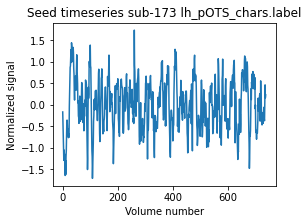

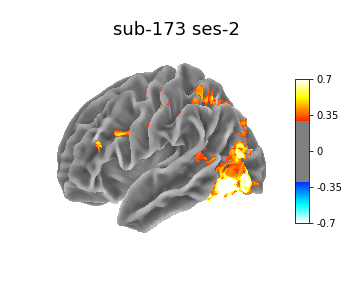

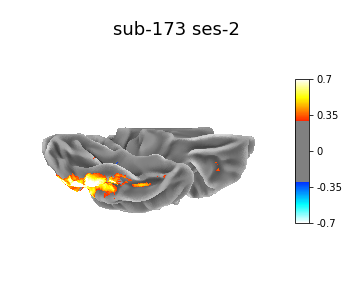

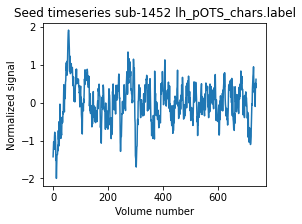

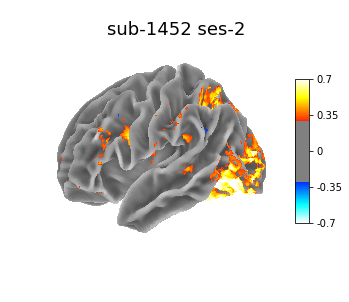

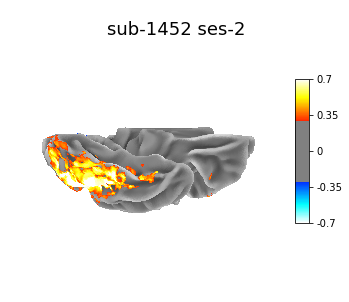

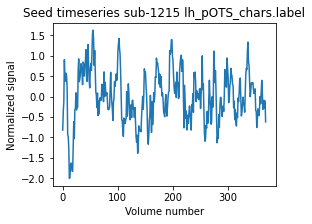

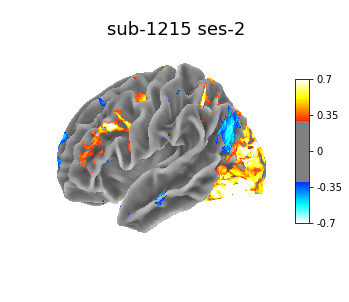

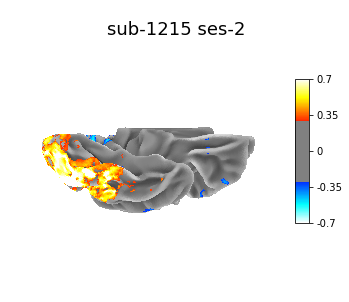

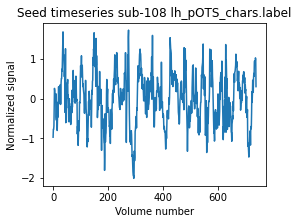

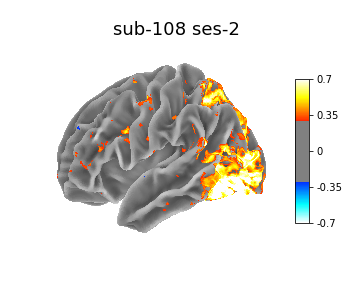

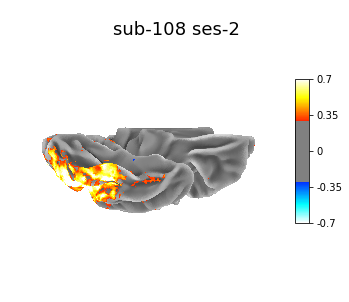

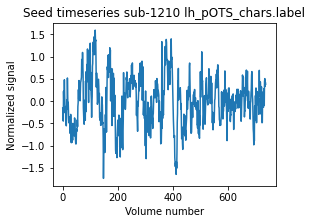

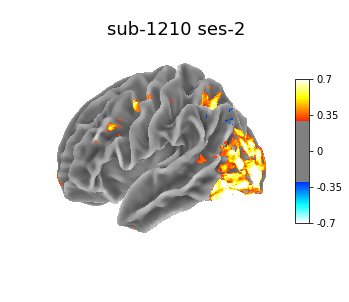

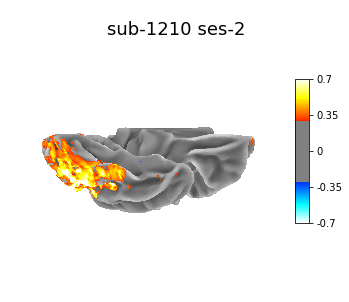

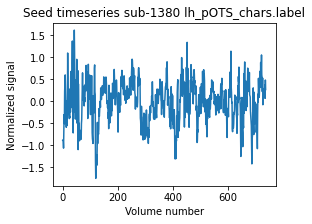

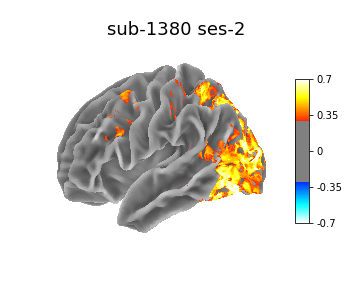

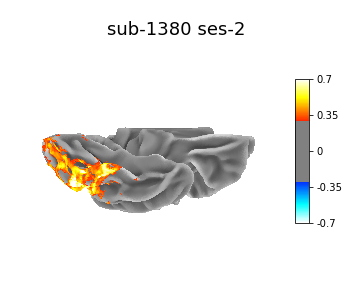

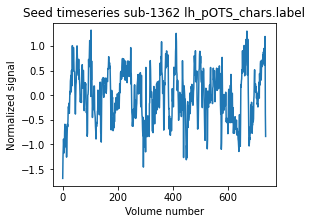

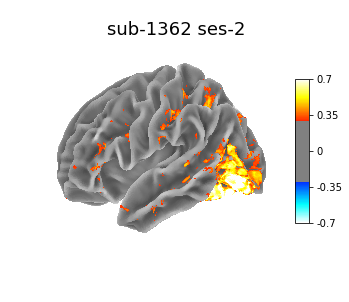

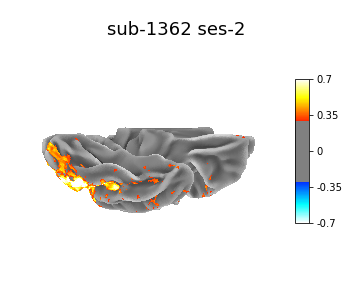

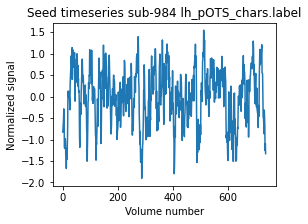

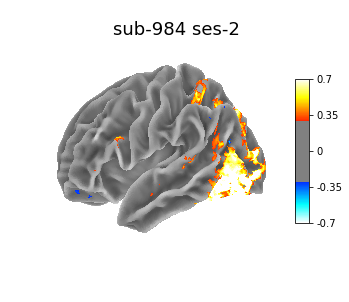

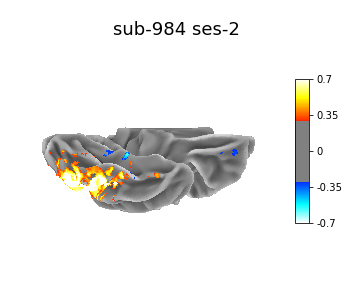

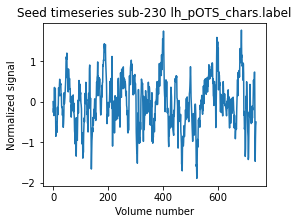

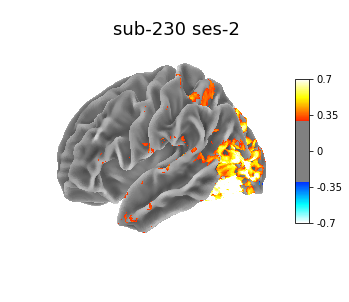

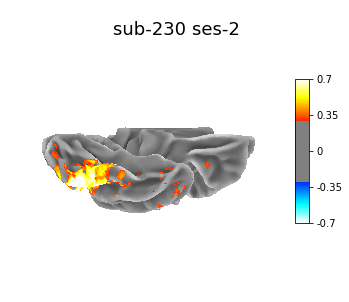

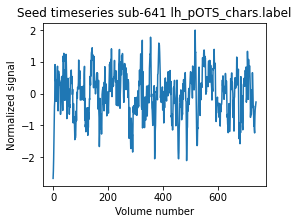

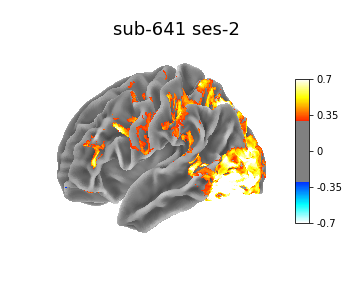

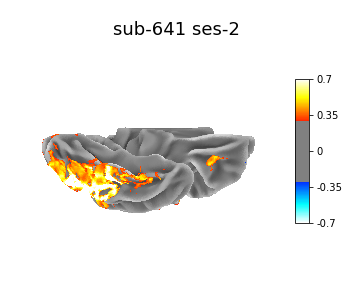

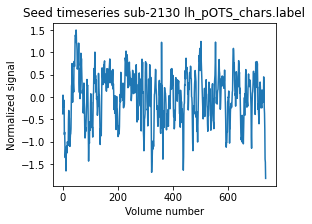

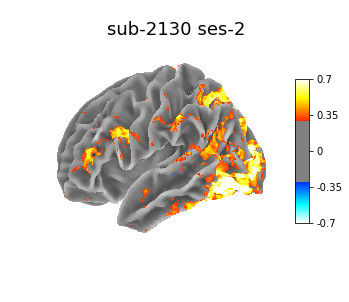

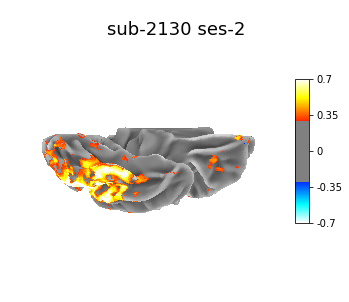

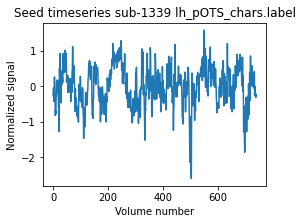

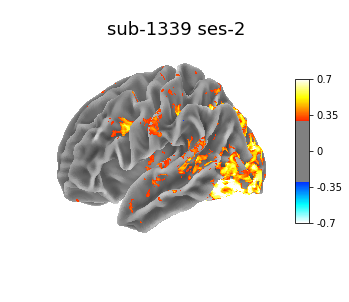

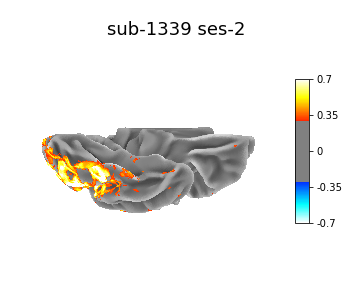

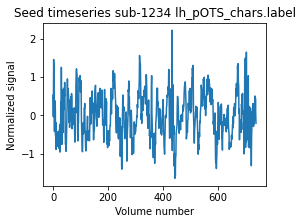

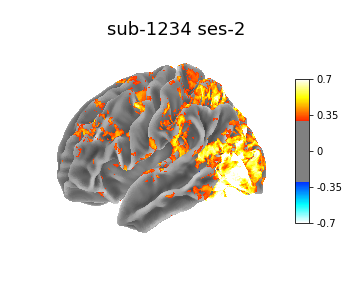

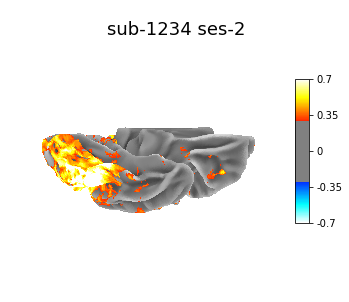

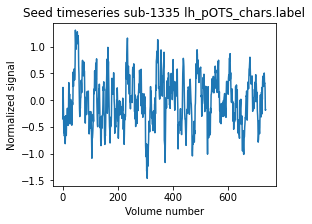

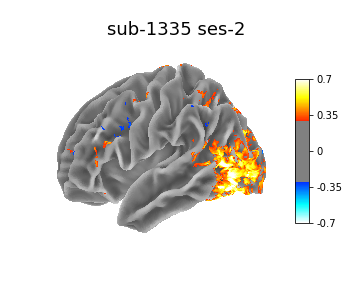

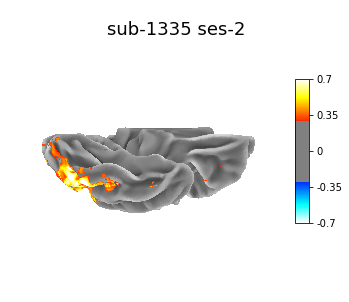

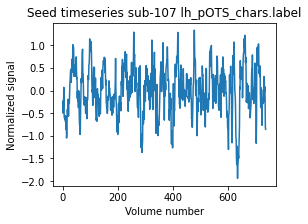

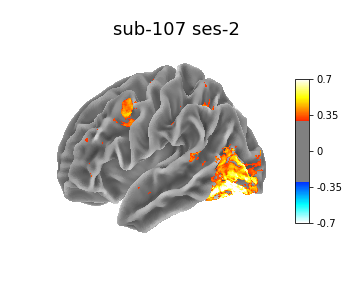

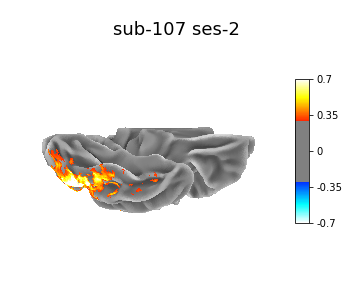

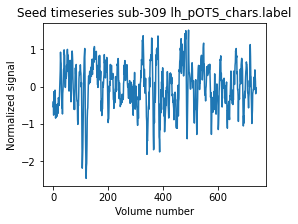

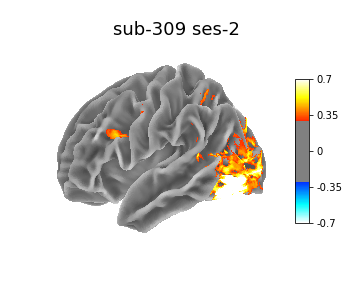

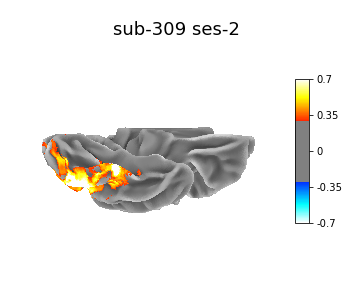

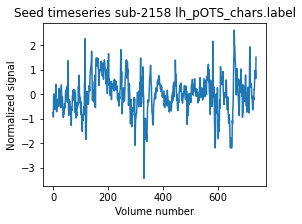

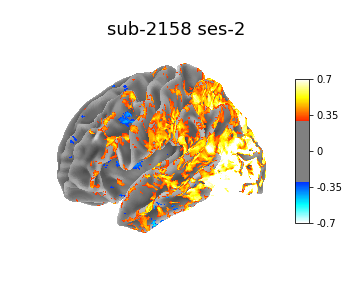

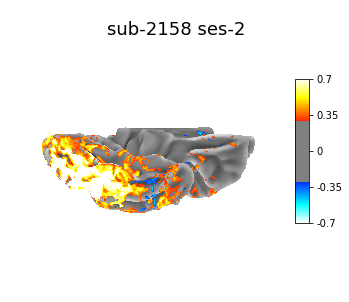

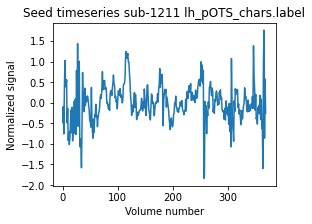

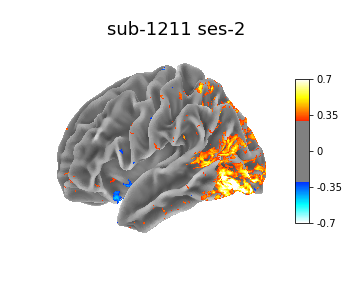

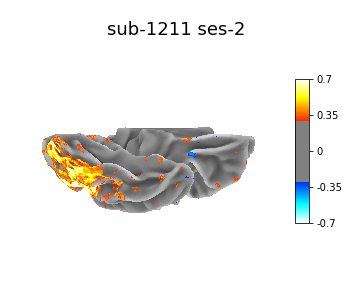

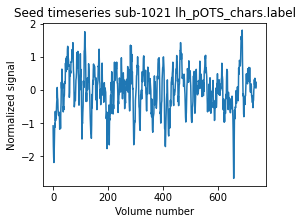

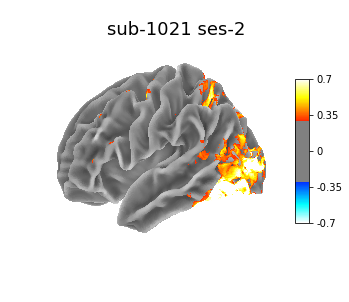

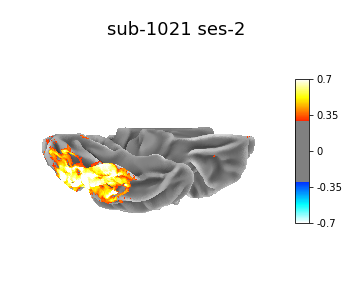

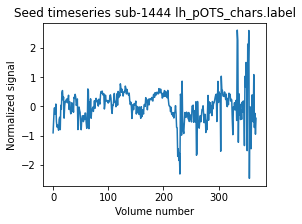

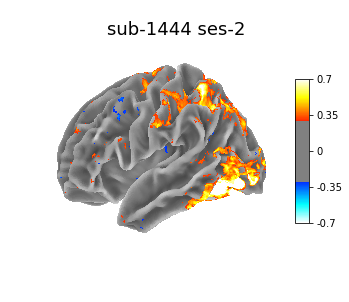

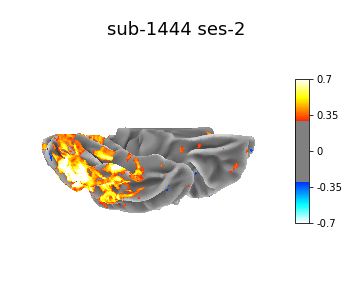

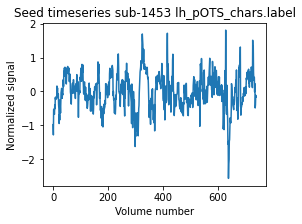

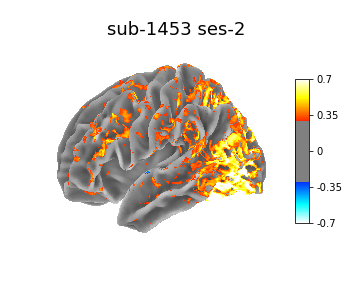

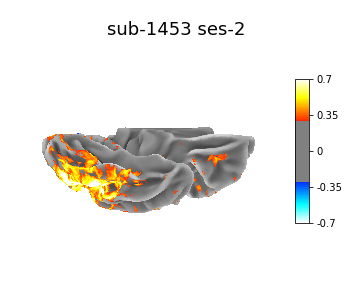

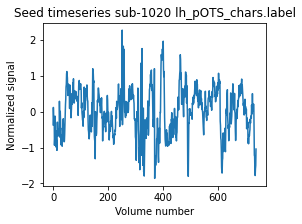

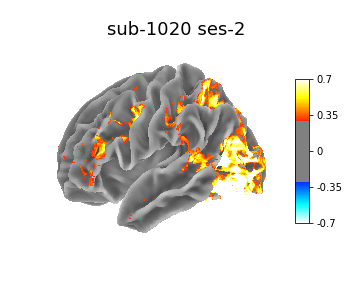

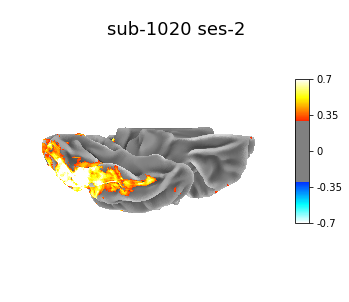

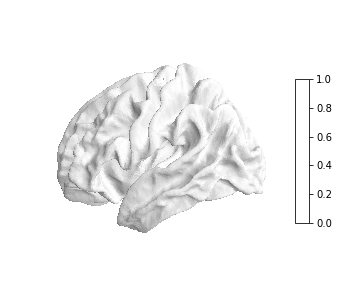

In [34]:
# For each ROI, calculate the seed-to-voxel whole-brain Pearson correlation on the surface
# Following this tutorial: https://nilearn.github.io/auto_examples/01_plotting/plot_surf_stat_map.html

for rr in range(len(roi_names)):
    # Load first ROI
    cur_roi = surface.load_surf_data(roidir + roi_names[rr])
    print('Analyzing ROI ' + roidir + roi_names[rr])
    
    # Loop over sessions and subjects and compute connectivity for that ROI
    for sesid in sessions:
        for ii in range(len(subs)):
            sub_dir = (datadir + subs[ii] + '/ses-' + sesid + '/func/')
            #run_data = np.zeros(shape = white_left[0].shape[0],len(runs)*(timepoints - len(droptp)))
            run_data = None
            for runid in runs:
                cur_run_gii = (sub_dir + subs[ii] + '_ses-' + sesid + '_task-rest_run-' + runid + '_space-fsaverage_hemi-L_bold.func.gii')
                print('Loading data for participant ' + subs[ii])
                if not exists(cur_run_gii):
                    print('Cant find ' + cur_run_gii)
                else:
                    print('Loading run ' + runid + ':' + cur_run_gii)
                    cur_run = surface.load_surf_data(cur_run_gii)

                    # Loading confounds
                    cur_con_all = pd.read_csv(sub_dir + subs[ii] + '_ses-' + sesid + '_task-rest_run-' + runid + '_desc-confounds_timeseries.tsv', sep = '\t')

                    cur_con = cur_con_all[['csf', 'white_matter','trans_x', 'trans_x_derivative1', 'trans_y','trans_y_derivative1','trans_z', 
                             'trans_z_derivative1', 'rot_x', 'rot_x_derivative1','rot_y','rot_y_derivative1', 
                             'rot_z', 'rot_z_derivative1']]
                   # TBD - create external function that takes a list of confounds
                    print('Original Data Vertices by Timepoints')
                    print(cur_run.shape)
                    cur_run = np.delete(cur_run,droptp,axis=1)

                    cur_con = cur_con.drop(droptp)

                    print('Vertices by Timepoints after dropping initial 6 timepoints')
                    print(cur_run.shape)
                    print('Number of confounds: ' + str(cur_con.shape[1]))
                    print('Number of timepoints: ' + str(cur_con.shape[0]))
                    
                    # Signal clean
                    cur_run = np.transpose(signal.clean(signals = np.transpose(cur_run), filter=None, detrend=True, standardize='zscore',confounds = cur_con))
                    if run_data is None:
                        run_data = cur_run
                    else:
                        run_data = np.concatenate((run_data,cur_run),axis=1)
                    print(run_data.shape)

            if run_data is None:
                # To keep track of the right N in the analysis
                sub_count = sub_count - 1
                # If subject has no data fill the array with nans, not zeros, to avoid influencing the mean
                # This causes issues with plotting - later on impute with means
                group_map[ii,:] = np.NaN 
                continue
            else:
                # Compute the mean time series for the ROI
                seed_timeseries = np.nanmean(run_data[cur_roi], axis=0)

                # Compute correlations between the seed timeseries and each vertex
                stat_map = np.zeros(cur_run.shape[0])
                for i in range(cur_run.shape[0]): # this loops through the vertices
                    stat_map[i] = stats.pearsonr(seed_timeseries, run_data[i])[0]

                
                # Fisher transform the map
                stat_map_fisher_z = np.arctanh(stat_map)
                
                # Save as a gifti that could be loaded into freeview
                if saveMaps:
                    targetFile = surfacedir + subs[ii] + '_ses-' + sesid + '_connectivity_' + roi_names[rr] + '.curv'
                    nib.freesurfer.io.write_morph_data(targetFile,stat_map_fisher_z)

                    
                # Add the stat map to the group stat map
                #group_map[:,ii] = stat_map
                group_map[ii,:] = stat_map_fisher_z # Try to transpose so we have subjects as rows and vertices as columns

                # Now plot the seed based connectivity
                figTitle = subs[ii] + ' ses-' + sesid + ''
                output_subfilename = imagedir + subs[ii] + '_ses-' + sesid + '_' + roi_names[rr]

                if saveFigs:
                    output_filel = output_subfilename + '_lateral.png'
                    output_filev = output_subfilename + '_ventral.png'
                    print('Saving ' + output_filel)
                else: 
                    output_filel = None
                    output_filev = None
               
                plotting.plot_surf_stat_map(fsaverage['white_left'], stat_map=stat_map_fisher_z,
                hemi='left', threshold = .3, vmax=0.7, view='lateral', colorbar=True,
                bg_map=fsaverage['curv_left'], title=figTitle, output_file = output_filel)

                plotting.plot_surf_stat_map(fsaverage['white_left'], stat_map=stat_map_fisher_z,
                hemi='left', threshold = .3, vmax=0.7, view='ventral', colorbar=True,
                bg_map=fsaverage['curv_left'], title=figTitle, output_file = output_filev)


        # Calculate the mean for roi_names[rr]
        # Before that we need to impute any nans
        imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
        group_map_imputed = imputer.fit_transform(group_map)
        
        print('Calculating mean connectivity for ' + roi_names[rr])
        group_mean = np.mean(group_map, axis = 0)
        
        output_groupfilename = surfacedir + 'GroupMap_ses-' + sesid + '_' + roi_names[rr] + '_N' + str(sub_count) + '_lateral.png'
        #save also as numpy array
        np.save(output_groupfilename[:-12],group_map)
        
        if saveFigs:
            output_file = output_groupfilename
        else:
            output_file = None
            
        plotting.plot_surf_stat_map(fsaverage['white_left'], stat_map=group_mean,
        hemi='left', threshold = .25, vmax=0.7, view='lateral', colorbar=True,
        bg_map=fsaverage['curv_left'],title='Group map ses-' + sesid + ' N=' + str(sub_count), output_file = output_file)
        
        if saveGroup:
            group_filename = surfacedir + 'GroupMean_' + 'ses-' + sesid + '_' + roi_names[rr] + '_N' + str(sub_count) + '.curv'
            nib.freesurfer.io.write_morph_data(group_filename,group_mean)


In [35]:
subs[ii]

'sub-1020'

In [32]:
group_mean = np.mean(group_map, axis = 0)
print(group_map.shape)
print(group_map_imputed.shape)

(3, 163842)
(3, 149955)


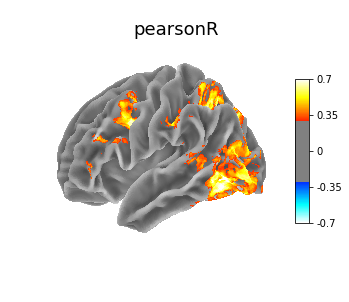

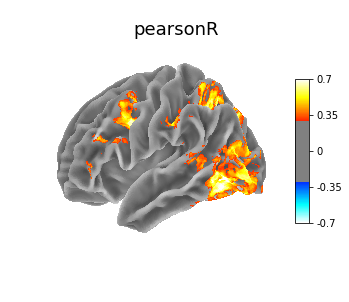

In [6]:
plotting.plot_surf_stat_map(fsaverage['white_left'], stat_map=stat_map,
hemi='left', threshold = .3, vmax=0.7, view='lateral', colorbar=True,
bg_map=fsaverage['curv_left'], title='pearsonR', output_file = None)

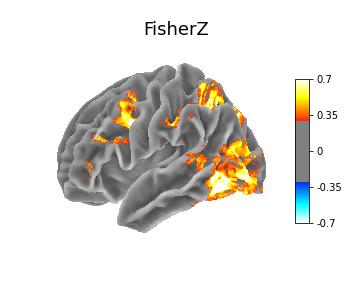

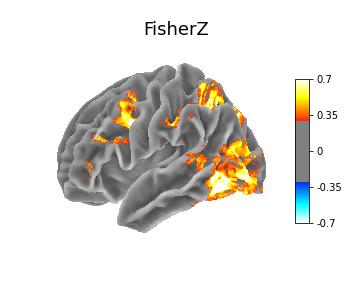

In [8]:
plotting.plot_surf_stat_map(fsaverage['white_left'], stat_map=stat_map_fisher_z,
hemi='left', threshold = .3, vmax=0.7, view='lateral', colorbar=True,
bg_map=fsaverage['curv_left'], title='FisherZ', output_file = None)

In [35]:
collist = cur_con_all.columns.tolist()
# command tolist makes sure we see all columns and not get ...

['global_signal', 'global_signal_derivative1', 'global_signal_power2', 'global_signal_derivative1_power2', 'csf', 'csf_derivative1', 'csf_derivative1_power2', 'csf_power2', 'white_matter', 'white_matter_derivative1', 'white_matter_derivative1_power2', 'white_matter_power2', 'csf_wm', 'tcompcor', 'std_dvars', 'dvars', 'framewise_displacement', 'rmsd', 't_comp_cor_00', 't_comp_cor_01', 't_comp_cor_02', 't_comp_cor_03', 'a_comp_cor_00', 'a_comp_cor_01', 'a_comp_cor_02', 'a_comp_cor_03', 'a_comp_cor_04', 'a_comp_cor_05', 'a_comp_cor_06', 'a_comp_cor_07', 'a_comp_cor_08', 'a_comp_cor_09', 'a_comp_cor_10', 'a_comp_cor_11', 'a_comp_cor_12', 'a_comp_cor_13', 'a_comp_cor_14', 'a_comp_cor_15', 'a_comp_cor_16', 'a_comp_cor_17', 'a_comp_cor_18', 'a_comp_cor_19', 'a_comp_cor_20', 'a_comp_cor_21', 'a_comp_cor_22', 'a_comp_cor_23', 'a_comp_cor_24', 'a_comp_cor_25', 'a_comp_cor_26', 'a_comp_cor_27', 'a_comp_cor_28', 'a_comp_cor_29', 'a_comp_cor_30', 'a_comp_cor_31', 'a_comp_cor_32', 'a_comp_cor_33', '

In [30]:
print(group_map[100,:])
np.nanmean(group_map[100,:])

[0.03241971        nan 0.0901565 ]


0.061288104237586044

In [ ]:
# Transform ROI indices to a "roi_map" which is what nilearn calls a mask
# Plot this ROI on the cortical surface
cur_roi_map = np.zeros(run1.shape[0], dtype=int)
cur_roi_map[cur_roi] = 1
plotting.plot_surf_roi(fsaverage['white_left'], roi_map=cur_roi_map,
                       hemi='left', view='ventral',
                       bg_map=fsaverage['curv_left'], bg_on_data=True,
                       title= roi_names[rr] + ' Seed')

In [ ]:
# TBD Scrubbing - implement later
cur_con_all = pd.read_csv(sub_dir + subs[ii] + '_ses-' + sesid + '_task-rest_run-' + runid + '_desc-confounds_timeseries.tsv', sep = '\t')
fd = cur_con_all[['framewise_displacement']]
fd = fd.fillna(0)

# create scrub regressor to flag volumes with FD>0.5mm
scrub = np.zeros((len(fd), 1))
scrub = np.where(fd < 0.9, 0, 1)
conf['scrub'] = scrub
conf = conf.fillna(0)

In [ ]:
plt.plot(fd)
#plt.plot(scrub)
plt.plot(cur_con_all['motion_outlier07']) # motion regressors from fmriprep- ech marks a specific peak of motion
# so that they can be weighted differently in the resression. it means that each subject might have a different number 
# of these regressors
plt.plot(fd_diff)